# Word2vec implementation in Keras

In [1]:
# Imports
import requests
import collections
import os
import zipfile
import numpy as np
rng_seed = 399
np.random.seed(rng_seed)

import tensorflow as tf
tf.random.set_seed(rng_seed)
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Reshape, dot, Embedding
from tensorflow.keras.preprocessing.sequence import skipgrams, make_sampling_table
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from matplotlib import pyplot as plt

# Dimensionality reduction
import umap
from sklearn.manifold import TSNE

# Silence NumbaPerformanceWarning (for UMAP)
from numba.errors import NumbaPerformanceWarning
import warnings
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

# Clustering
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
import hdbscan

### Utility functions

In [2]:
def load_content_from_url(url: str, data_dir: str = 'data'):
    filename = f'{data_dir}{os.path.sep}{os.path.basename(url)}'
    
    # Download file if not present
    if not os.path.exists(filename):
        r = requests.get(url)
        with open(filename, 'wb', encoding='utf-8-sig') as f:
            f.write(r.content)
        return r.text
    else:
        with open(filename, 'r', encoding='utf-8-sig') as f:
            content = f.read()
    
    return content #.split()

In [3]:
def build_dataset(text: str, max_vocab_size: int, context_window_size: int, seed: int = rng_seed):
    
    # Tokenize the text
    tokenizer = Tokenizer(max_vocab_size)
    tokenizer.fit_on_texts([text])
    text_tokenized = text_to_word_sequence(text)
    
    # Extract word dictionary
    word_dict = tokenizer.word_index
    num_words = len(word_dict)
    rev_word_dict = tokenizer.index_word
    data = [word_dict[word] for word in text_tokenized]
    
    # Create data samples for valid context words and negative samples
    sampling_table = make_sampling_table(num_words + 1)
    pairs, labels = skipgrams(data, num_words, window_size=context_window_size, sampling_table=sampling_table, seed=seed)
    pairs = np.array(pairs)
    labels = np.array(labels)
    
    return data, (pairs, labels), word_dict, rev_word_dict, num_words

In [4]:
# Constants
max_vocab_size = 10000
context_window_size = 10
vector_dim = 300
num_epochs = 20
batch_size = 128

In [5]:
# Build dataset
# TODO: Sult? https://www.gutenberg.org/ebooks/search/?query=Sult+Knut+Hamsun
book_url = 'http://www.gutenberg.org/cache/epub/78/pg78.txt'
book_content = load_content_from_url(book_url)
book_data, (book_data_pairs, book_data_labels), book_dictionary, rev_book_dictionary, real_vocab_size = build_dataset(book_content, max_vocab_size, context_window_size)
del book_content # Save memory

In [6]:
# Split data into train/test
X_train, X_val, y_train, y_val = train_test_split(book_data_pairs, book_data_labels, test_size=0.02, random_state=rng_seed)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=rng_seed)

In [7]:
# Sanity checking
for i, target, context, label in zip(range(10), X_train[:, 0], X_train[:, 1], book_data_labels):
    print(f'Pair #{i + 1} - {rev_book_dictionary[target]} + {rev_book_dictionary[context]} --> {label}')

Pair #1 - xxvii + fungi --> 1
Pair #2 - inflicting + occurrences --> 0
Pair #3 - silent + had --> 1
Pair #4 - was + more --> 0
Pair #5 - share + expressed --> 0
Pair #6 - entire + this --> 0
Pair #7 - implied + 5 --> 0
Pair #8 - fine + modest --> 1
Pair #9 - only + in --> 0
Pair #10 - which + and --> 0


In [8]:
# Create the model
def build_model(vocab_size: int, vector_dim: int, optimizer='adam'):
    
    # Input to network
    input_target = Input((1,), name='input_target')
    input_context = Input((1,), name='input_context')

    # Embedding layer
    # TODO: Implement embedding myself.
    embedding = Embedding(vocab_size + 1, vector_dim, input_length=1, name='embedding')
    target = embedding(input_target)
    target = Reshape((vector_dim, 1), name='target_word_vector')(target)
    context = embedding(input_context)
    context = Reshape((vector_dim, 1), name='context_word_vector')(context)
    
    # Compute similarity (dot product)
    dot_product = dot([target, context], axes=1, normalize=False, name='dot_product')
    dot_product = Reshape((1,), name='dot_product_reshape')(dot_product)
    
    # Sigmoid activation (output)
    output = Dense(1, activation='sigmoid', name='sigmoid_activation')(dot_product)
    
    # Create model
    model = Model(inputs=[input_target, input_context], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [9]:
w2v_model = build_model(real_vocab_size, vector_dim)
w2v_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_target (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_context (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 300)       2327700     input_target[0][0]               
                                                                 input_context[0][0]              
__________________________________________________________________________________________________
target_word_vector (Reshape)    (None, 300, 1)       0           embedding[0][0]              

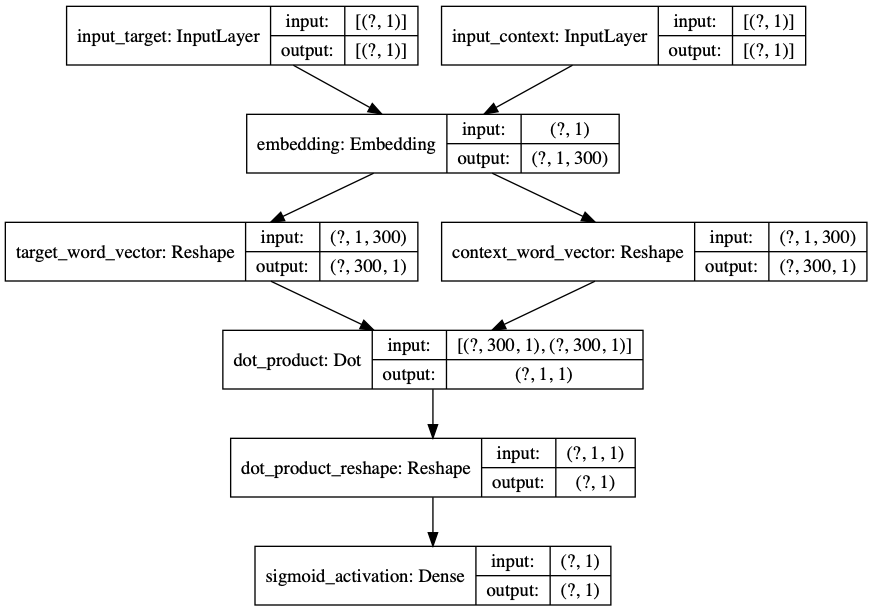

In [10]:
# Visualize model using PyDot and GraphViz
plot_model(w2v_model, show_shapes=True, to_file='word2vec_model.png')

In [11]:
# Load model from file
#w2v_model = load_model('word2vec_model.h5')

In [12]:
class IntermediateUMAPReductionCallback(Callback):
    def __init__(self, plot_embedding: bool = True, data: list = None, rev_data_dictionary: dict = None):
        self.plot_embedding = plot_embedding
        self.data = data
        self.rev_data_dictionary = rev_data_dictionary
        self.embeddings = []
    
    def get_embedding(self, epoch: int):
        assert epoch < len(self.embeddings), f'Invalid epoch number: {epoch}'
        return self.embeddings[epoch]
    
    def __plot_embedding__(self, epoch: int, num_words: int = 100):
        assert self.data != None, 'Data is required for plotting'
        assert self.rev_data_dictionary != None, 'Reversed data dictionary is required for plotting'
        embedding = self.get_embedding(epoch)
        
        # Plot embedded vectors in 2D
        plt.figure(figsize=(5, 5))
        plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.25)

        # Annotate
        for word_i in self.data[:num_words]:
            word = self.rev_data_dictionary[word_i]
            word_vec = embedding[word_i]
            plt.annotate(word, (word_vec[0], word_vec[1]))
        plt.show()
    
    def on_epoch_end(self, epoch, logs={}):
        print(f'Creating word embeddings...')
        
        # Create intermediate UMAP word embeddings
        word_embeddings = self.model.layers[2].get_weights()[0]
        word_embeddings_2d = umap.UMAP().fit_transform(word_embeddings)
        self.embeddings.append(word_embeddings_2d)
        
        if self.plot_embedding:
            self.__plot_embedding__(epoch)

In [57]:
# Define callbacks
checkpoint = ModelCheckpoint('checkpoints/model-best-{epoch:02d}.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='auto')  
umap_reduc = IntermediateUMAPReductionCallback(data=book_data, rev_data_dictionary=rev_book_dictionary)
cb = [checkpoint, umap_reduc]

# Uncomment to fit model
# model_hist = w2v_model.fit(list(X_train.T), y_train, batch_size=batch_size, epochs=num_epochs, callbacks=cb, validation_data=(list(X_val.T), y_val))

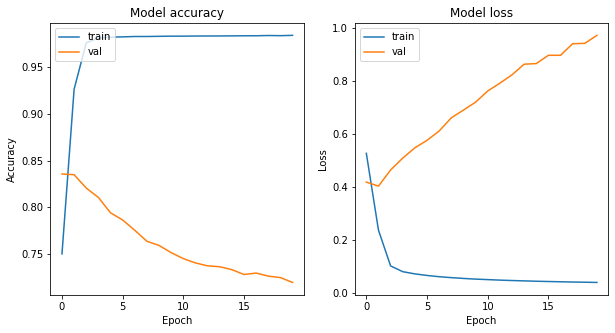

In [58]:
# Summarize history for accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(model_hist.history['accuracy'])
ax1.plot(model_hist.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(model_hist.history['loss'])
ax2.plot(model_hist.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
# Evaluate train accuracy
y_train_pred = w2v_model.predict(list(X_train.T))
y_train_acc = roc_auc_score(y_train, y_train_pred)
print(f'Train accuracy: {y_train_acc}')

Train accuracy: 0.9995667404379233


In [16]:
# Evaluate test accuracy
y_test_pred = w2v_model.predict(list(X_test.T))
y_test_acc = roc_auc_score(y_test, y_test_pred)
print(f'Test accuracy: {y_test_acc}')

Test accuracy: 0.814753224588573


In [56]:
# Save last model to file
#w2v_model.save('checkpoints/last_model.h5')

## Analyze word embeddings

In [59]:
# Load best model from file
best_model_path = 'checkpoints/last_model.h5'
w2v_model = load_model(best_model_path)

In [60]:
# Extract the learned embeddings from the NN
word_embeddings = w2v_model.layers[2].get_weights()[0]
word_embeddings_lst = list(word_embeddings)

In [19]:
word_embeddings_2d = umap.UMAP().fit_transform(word_embeddings)

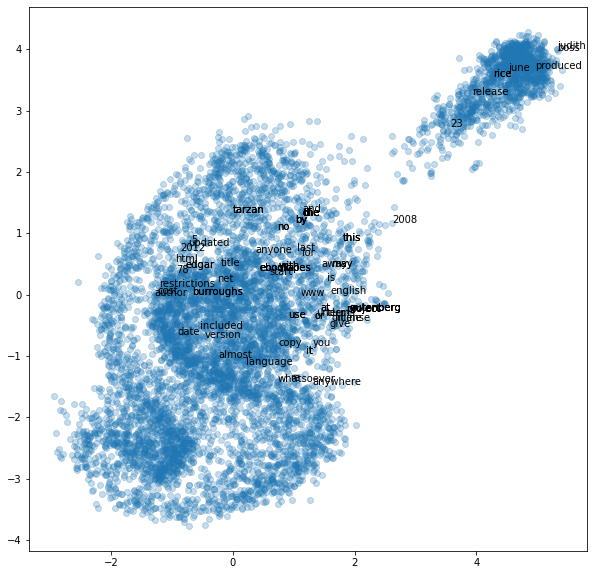

In [61]:
# Plot embedded vectors in 2D
plt.figure(figsize=(10, 10))
plt.scatter(word_embeddings_2d[:, 0], word_embeddings_2d[:, 1], alpha=0.25)

# Annotate
for word_i in book_data[:100]:
    word = rev_book_dictionary[word_i]
    word_vec = word_embeddings_2d[word_i]
    plt.annotate(word, (word_vec[0], word_vec[1]))
plt.show()

In [21]:
# Tarzan - Man + Woman = Jane?
tarzan_vec = word_embeddings[book_dictionary['tarzan']]
man_vec = word_embeddings[book_dictionary['man']]
woman_vec = word_embeddings[book_dictionary['woman']]
jane_vec = word_embeddings[book_dictionary['jane']]
jane_vec_pred = tarzan_vec - man_vec + woman_vec

### Utility functions

In [29]:
def distance(a: np.ndarray, b: np.ndarray):
    '''
    TODO: Docs
    '''
    return np.linalg.norm(a - b)

def closest(target: np.ndarray, word_embeddings: np.ndarray, rev_book_dictionary: dict, n: int=10):
    '''
    TODO: Docs
    '''
    target_mat = np.tile(target, (word_embeddings.shape[0], 1))
    diff = word_embeddings - target_mat
    distances = np.linalg.norm(diff, axis=1)
    sorted_order = np.argsort(distances)[:n]
    closest_words = [rev_book_dictionary[idx + 1] for idx in sorted_order]
    return closest_words

In [41]:
# TODO: Find top words close to jane_vec_pred
print(closest(jane_vec_pred, word_embeddings, rev_book_dictionary))

['back', 'patiently', 'comparatively', 'the', 'epicures', 'mine', 'recollect', 'resent', 'binary', 'count']
['why', 'him', 'francs', 'patiently', 'confiscated', 'binary', 'vegetation', 'lightning', 'the', 'killed']


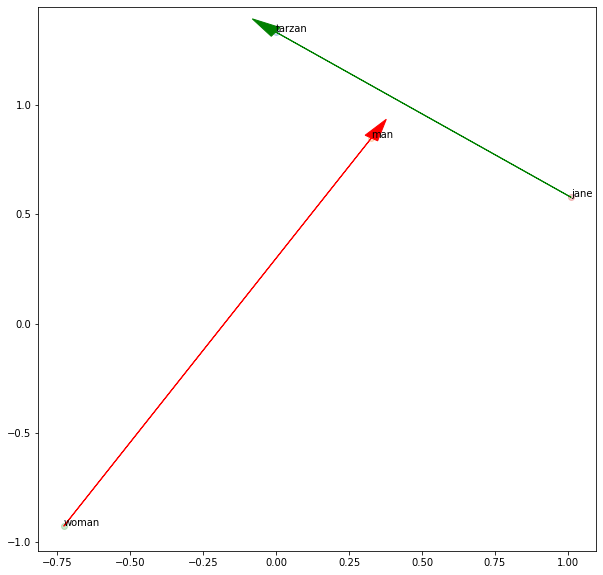

In [55]:
# Plotting tarzan, man, woman, jane
target_words = ['tarzan', 'man', 'woman', 'jane']
target_word_vecs = [word_embeddings_2d[book_dictionary[word]] for word in target_words]

plt.figure(figsize=(10, 10))
for word, word_vec in zip(target_words, target_word_vecs):
    plt.scatter(word_vec[0], word_vec[1], alpha=0.25)
    plt.annotate(word, (word_vec[0], word_vec[1]))

man_to_woman = target_word_vecs[target_words.index('man')] - target_word_vecs[target_words.index('woman')]
tarzan_to_jane = target_word_vecs[target_words.index('tarzan')] - target_word_vecs[target_words.index('jane')]
plt.arrow(*target_word_vecs[target_words.index('woman')], *man_to_woman, head_width=0.05, head_length=0.1, color='r')
plt.arrow(*target_word_vecs[target_words.index('jane')], *tarzan_to_jane, head_width=0.05, head_length=0.1, color='g')
    
plt.show()

# Scrapyard

In [24]:
'''
def build_dataset(words: list, num_words: int = -1):
    
    # Create a dictionary for word counts
    count = [['UNK', -1]]
    if num_words == -1:
        num_words = len(words)
        
    # TODO: Fix words
    count.extend(collections.Counter(words).most_common(num_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

    return data, count, dictionary, reversed_dictionary
'''

"\ndef build_dataset(words: list, num_words: int = -1):\n    \n    # Create a dictionary for word counts\n    count = [['UNK', -1]]\n    if num_words == -1:\n        num_words = len(words)\n        \n    # TODO: Fix words\n    count.extend(collections.Counter(words).most_common(num_words - 1))\n    dictionary = dict()\n    for word, _ in count:\n        dictionary[word] = len(dictionary)\n    \n    data = list()\n    unk_count = 0\n    for word in words:\n        if word in dictionary:\n            index = dictionary[word]\n        else:\n            index = 0  # dictionary['UNK']\n            unk_count += 1\n        data.append(index)\n    count[0][1] = unk_count\n    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))\n\n    return data, count, dictionary, reversed_dictionary\n"